Loading model and tokenizer...
Model loaded successfully.



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



Final Layer Cosine Similarity (Mean ± 95% CI)
Center  : 0.9883 ± 0.0005
Edge    : 0.7135 ± 0.0021
Corner  : 0.3090 ± 0.0023



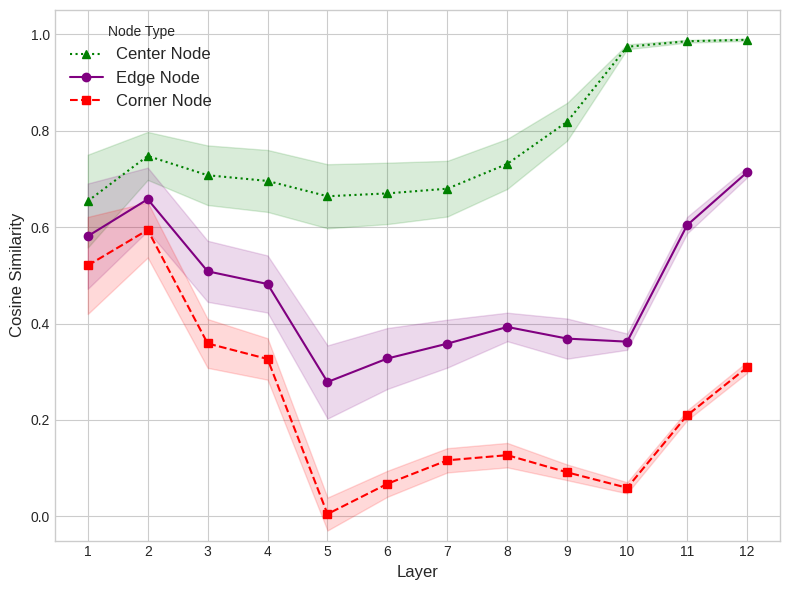

In [ ]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import networkx as nx
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/model_chunked/checkpoint-73125"
GRID_SIZE = 4
WALK_LENGTH = 100
NUM_RUNS_PER_TYPE = 100

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

def generate_grid_graph(size=4):
    """Generates a grid graph with coordinate metadata."""
    G = nx.DiGraph()
    nodes = [f"{chr(97+r)}{chr(97+c)}" for r in range(size) for c in range(size)]
    direction_map = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            G.add_node(nodes[idx], coords=(r, c))
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction=direction_map['E'])
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction=direction_map['W'])
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction=direction_map['S'])
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction=direction_map['N'])
    return G

def generate_random_walk(G, start_node, length):
    """Generate a random walk of specified length."""
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    """Convert walk to string format."""
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    return " ".join(parts) + f" {walk[-1]}"

def swap_directions_robust(prompt):
    swap_map = {'NORTH': 'SOUTH', 'SOUTH': 'NORTH', 'EAST': 'WEST', 'WEST': 'EAST'}
    return ' '.join([swap_map.get(part, part) for part in prompt.split(' ')])

def get_hidden_states(model, tokens):
    cache = {}
    hooks = []
    def save_hook(layer_idx):
        def hook_fn(module, input, output):
            cache[layer_idx] = output[0].detach().cpu()
        return hook_fn
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(save_hook(i)))
    with torch.no_grad():
        model(**tokens)
    for h in hooks: h.remove()
    return [cache[i] for i in range(model.config.n_layer)]

def run_direction_swap_experiment(model, tokenizer, G, walk_type='corner'):
    coords = nx.get_node_attributes(G, 'coords')
    target_nodes = []
    if walk_type == 'center':
        center_coords = [(r, c) for r in range(1, GRID_SIZE-1) for c in range(1, GRID_SIZE-1)]
        target_nodes = [n for n, (r, c) in coords.items() if (r, c) in center_coords]
    elif walk_type == 'edge':
        edge_nodes = []
        corners = [(0,0), (0,GRID_SIZE-1), (GRID_SIZE-1,0), (GRID_SIZE-1,GRID_SIZE-1)]
        for n, (r, c) in coords.items():
            is_on_border = (r == 0 or r == GRID_SIZE - 1 or c == 0 or c == GRID_SIZE - 1)
            if is_on_border and (r, c) not in corners:
                edge_nodes.append(n)
        target_nodes = edge_nodes
    elif walk_type == 'corner':
        corners = [(0,0), (0,GRID_SIZE-1), (GRID_SIZE-1,0), (GRID_SIZE-1,GRID_SIZE-1)]
        target_nodes = [n for n, (r, c) in coords.items() if (r, c) in corners]
    else:
        raise ValueError("walk_type must be 'center', 'edge', or 'corner'")
    if not target_nodes:
        raise ValueError(f"No target nodes found for walk_type '{walk_type}'")

    target_node = random.choice(target_nodes)
    while True:
        start_node = random.choice(list(G.nodes()))
        walk = generate_random_walk(G, start_node, WALK_LENGTH)
        if walk[-1] == target_node:
            break

    base_prompt = walk_to_string(walk, G)
    original_prompt = base_prompt + " "
    swapped_prompt = swap_directions_robust(base_prompt) + " "
    
    orig_tokens = tokenizer(original_prompt, return_tensors="pt").to(DEVICE)
    swap_tokens = tokenizer(swapped_prompt, return_tensors="pt").to(DEVICE)
    
    orig_hiddens = get_hidden_states(model, orig_tokens)
    swap_hiddens = get_hidden_states(model, swap_tokens)

    cos_sims = []
    for i in range(model.config.n_layer):
        h1 = orig_hiddens[i][0, -1, :].numpy()
        h2 = swap_hiddens[i][0, -1, :].numpy()
        cos_sim = np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2) + 1e-8)
        cos_sims.append(cos_sim)
        
    return cos_sims

def plot_averaged_swap_figure(model, tokenizer, G):
    """
    Runs the swap experiment multiple times for each condition, then plots the
    mean similarity with standard deviation error bands.
    """
    all_results = {'center': [], 'edge': [], 'corner': []}
    
    for walk_type in ['center', 'edge', 'corner']:
        print(f"\nCollecting data for '{walk_type}' case ({NUM_RUNS_PER_TYPE} runs)...")
        for _ in tqdm(range(NUM_RUNS_PER_TYPE)):
            sims = run_direction_swap_experiment(model, tokenizer, G, walk_type)
            all_results[walk_type].append(sims)

    mean_sims = {}
    std_sims = {}
    for walk_type, results in all_results.items():
        results_array = np.array(results)
        mean_sims[walk_type] = np.mean(results_array, axis=0)
        std_sims[walk_type] = np.std(results_array, axis=0)

    print("\n" + "="*50)
    print("Final Layer Cosine Similarity (Mean ± 95% CI)")
    print("="*50)

    z_score = 1.96 # For 95% confidence interval
    for walk_type in ['center', 'edge', 'corner']:
        final_layer_mean = mean_sims[walk_type][-1]
        final_layer_std = std_sims[walk_type][-1]
        
        # Calculate standard error and the confidence interval margin
        standard_error = final_layer_std / np.sqrt(NUM_RUNS_PER_TYPE)
        ci_margin = z_score * standard_error
        
        print(f"{walk_type.capitalize():<8}: {final_layer_mean:.4f} ± {ci_margin:.4f}")
    print("="*50 + "\n")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))

    layers = np.arange(1, model.config.n_layer + 1)
    
    colors = {'center': 'green', 'edge': 'purple', 'corner': 'red'}
    styles = {'center': ':', 'edge': '-', 'corner': '--'}
    markers = {'center': '^', 'edge': 'o', 'corner': 's'}
    labels = {'center': 'Center Node', 'edge': 'Edge Node', 'corner': 'Corner Node'}

    for walk_type in ['center', 'edge', 'corner']:
        mean = mean_sims[walk_type]
        std = std_sims[walk_type]
        
        ax.plot(layers, mean, marker=markers[walk_type], linestyle=styles[walk_type], 
                color=colors[walk_type], label=labels[walk_type])
        
        ax.fill_between(layers, mean - std, mean + std, color=colors[walk_type], alpha=0.15)
    
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Cosine Similarity", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(layers)
    ax.legend(fontsize=12, title="Node Type")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
    
    G = generate_grid_graph(size=GRID_SIZE)
    
    plot_averaged_swap_figure(model, tokenizer, G)